In [1]:
""" Semantic Segmentation Using U-Net Architecture  """

################################################
#       Author: Mohamed Hassan Oraby           #
#        Created on: Oct 25, 2022              #
################################################

""" Dataset  """
# https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge
# This dataset provides data images and labeled semantic segmentations captured via CARLA self-driving car simulator. The data was generated as part of the Lyft Udacity Challenge

""" U-Net paper  """
# [Ronneberger et al., U-Net: Convolutional Networks for Biomedical Image Segmentation] , arXiv:1505.04597v1 [cs.CV]

' U-Net paper  '

In [1]:
# imports cell
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchsummary import summary

from sklearn.model_selection import train_test_split

from copy import deepcopy
from tqdm import tqdm
import random
import warnings
import gc

# to create a tensor on the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings('ignore')

In [2]:
image_path = ["./lyft-udacity-challenge/data" + i + "/" + "data" + i + "/CameraRGB/" for i in
              ['A', 'B', 'C', 'D', 'E']]
mask_path = ["./lyft-udacity-challenge/" + "data" + i + "/" + "data" + i + "/CameraSeg/" for i in
             ['A', 'B', 'C', 'D', 'E']]

image_path

['./lyft-udacity-challenge/dataA/dataA/CameraRGB/',
 './lyft-udacity-challenge/dataB/dataB/CameraRGB/',
 './lyft-udacity-challenge/dataC/dataC/CameraRGB/',
 './lyft-udacity-challenge/dataD/dataD/CameraRGB/',
 './lyft-udacity-challenge/dataE/dataE/CameraRGB/']

In [3]:
def list_image_paths(directory_paths):
    image_paths = []

    for i in range(len(directory_paths)):  # 5 folders
        image_filenames = os.listdir(directory_paths[i])

        for image_filename in image_filenames:
            image_paths.append(directory_paths[i] + image_filename)

    return image_paths

In [4]:
image_list = list_image_paths(image_path)
mask_list = list_image_paths(mask_path)

image_list

['./lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_000.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_001.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_010.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_011.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_020.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_021.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_030.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_031.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_040.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_041.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_050.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_051.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_060.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_061.png',
 './lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_070.png',
 './lyft-udacity-challeng

In [5]:
labels = {'Unlabeled': 0,
          'Building': 1,
          'Fence': 2,
          'Other': 3,
          'Pedestrian': 4,
          'Pole': 5,
          'Roadline': 6,
          'Road': 7,
          'Sidewalk': 8,
          'Vegetation': 9,
          'Car': 10,
          'Wall': 11,
          'Traffic sign': 12}

colors_platte = np.array([[0, 0, 0],  # Unlabeled
                           [70, 70, 70],  # Building
                           [100, 40, 40],  # Fence
                           [55, 90, 80],  # Other -> Everything that does not belong to any other category.
                           [220, 20, 60],  # Pedestrian
                           [153, 153, 153],  # Pole
                           [157, 234, 50],  # Roadline
                           [128, 64, 128],  # Road
                           [244, 35, 232],  # Sidewalk
                           [107, 142, 35],  # Vegetation
                           [0, 0, 142],  # Car
                           [102, 102, 156],  # Wall
                           [220, 220, 0],  # Traffic sign
                           # not used in current model
                           [70, 130, 180],  # Sky
                           [81, 0, 81],  # Ground
                           [150, 100, 100],  # Bridge
                           [230, 150, 140],  # RailTrack
                           [180, 165, 180],  # GuardRail
                           [250, 170, 30],  # TrafficLight
                           [110, 190, 160],  # Static
                           [170, 120, 50],  # Dynamic
                           [45, 60, 150],  # Water
                           [145, 170, 100]] )# Terrain

In [6]:
IMG_HEIGHT = 600
IMG_WIDTH = 800

RESIZE_HEIGHT = 240
RESIZE_WIDTH = 320

BATCH_SIZE = 16


((600, 800, 3), (600, 800, 3))

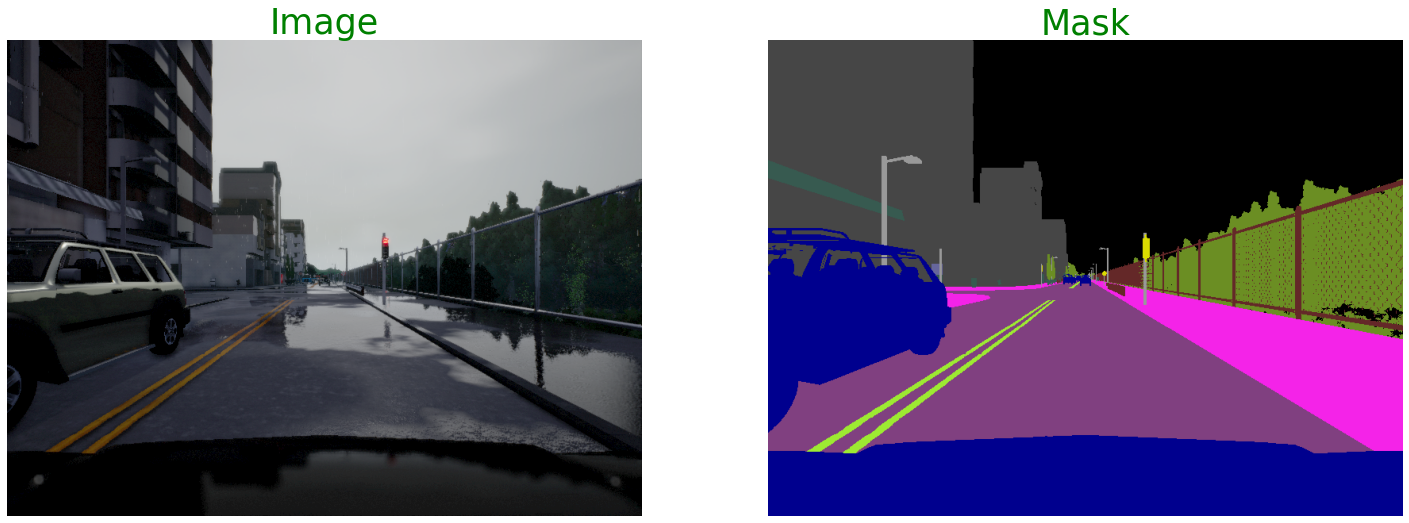

In [9]:
img = cv2.cvtColor(cv2.imread(image_list[0]), cv2.COLOR_BGR2RGB)

msk = cv2.imread(mask_list[0])
msk = np.max(msk, axis=-1)
msk = colors_platte[msk]

fig, arr = plt.subplots(1, 2, figsize=(25, 25))

arr[0].set_title('Image', color="green", fontsize=35)
arr[0].imshow(img)
arr[0].axis("off")

arr[1].set_title('Mask', color="green", fontsize=35)
arr[1].imshow(msk)
arr[1].axis("off")

img.shape, msk.shape

In [9]:
images = []
for image in image_list:
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    img = img.astype("float32") / 255.0
    images.append(img)

masks = []
for mask in mask_list:
    msk = cv2.cvtColor(cv2.imread(mask), cv2.COLOR_BGR2RGB)
    msk = cv2.resize(msk, (RESIZE_WIDTH, RESIZE_HEIGHT))
    msk = np.max(msk, axis=-1)
    masks.append(msk)

masks = np.array(masks)
images = np.array(images).transpose((0, 3, 1, 2))

images.shape, masks.shape

((5000, 3, 240, 320), (5000, 240, 320))

In [10]:
x_train_val, x_test, y_train_val, y_test = train_test_split(images, masks, test_size=0.2,
                                                            random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)

In [11]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((3000, 3, 240, 320),
 (3000, 240, 320),
 (1000, 3, 240, 320),
 (1000, 240, 320),
 (1000, 3, 240, 320),
 (1000, 240, 320))

In [12]:
class SegmentationDataset(Dataset):
    def __init__(self, _images, _masks, transform=None):
        self.images = _images
        self.masks = _masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        _img = self.images[index]
        _mask = self.masks[index]

        if self.transform is not None:
            image_tensor = self.transform(_img).to(device)
        else:
            image_tensor = torch.tensor(_img, dtype=torch.float32, device=device)

        mask_tensor = torch.tensor(_mask, dtype=torch.long, device=device)

        return image_tensor, mask_tensor

In [13]:
trainDataset = SegmentationDataset(x_train, y_train)

train_dataloader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
valDataset = SegmentationDataset(x_val, y_val)

val_dataloader = DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
testDataset = SegmentationDataset(x_test, y_test)

test_dataloader = DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
# Encoder (Down-sampling Block)
# The encoder is a stack of various conv blocks
class DownSamplingBlock(nn.Module):
    def __init__(self, inChannels, n_filters, dropout_prob=0.0, max_pooling=True):
        super().__init__()
        self.dropout_prob = dropout_prob
        self.max_pooling = max_pooling

        self.conv1 = nn.Conv2d(in_channels=inChannels, out_channels=n_filters, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(n_filters)

        self.conv2 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(n_filters)

        if dropout_prob > 0.0:
            self.drop = nn.Dropout(p=dropout_prob)

        if max_pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

    def forward(self, x):
        conv = F.relu(self.bn1(self.conv1(x)))

        conv = F.relu(self.bn2(self.conv2(conv)))

        if self.dropout_prob > 0.0:
            conv = self.drop(conv)

        if self.max_pooling:
            next_layer = self.pool(conv)

        else:
            next_layer = conv

        skip_connection = conv

        return next_layer, skip_connection

In [17]:
# Decoder (Up-sampling Block)
# Takes the arguments expansive_input (which is the input tensor from the previous layer) and contractive_input (the input tensor from the previous skip layer)
class UpSamplingBlock(nn.Module):
    def __init__(self, inChannels, n_filters):
        super().__init__()

        # out = (in-1)*s -2p + d(k-1) + op + 1
        self.upSample = nn.ConvTranspose2d(in_channels=inChannels, out_channels=n_filters, kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=inChannels, out_channels=n_filters, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(n_filters)

        self.conv2 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(n_filters)

    def forward(self, expansive_input, contractive_input):
        up = self.upSample(expansive_input)

        if up.shape != contractive_input.shape:
            # crop the contractive input to fit the Up sampled expansive input
            (B, C, H, W) = up.shape
            contractive_input = transforms.CenterCrop([H, W])(contractive_input)

        merge = torch.cat([up, contractive_input], dim=1)

        conv = F.relu(self.bn1(self.conv1(merge)))

        conv = F.relu(self.bn2(self.conv2(conv)))

        return conv

In [18]:
class UNet(nn.Module):
    def __init__(self, inChannels=3, n_filters=64, n_classes=13):
        super().__init__()

        encChannels = (inChannels, n_filters, 128, 256, 512, 1024)
        decChannels = (1024, 512, 256, 128, n_filters)

        self.encBlocks = nn.ModuleList([
            DownSamplingBlock(encChannels[i], encChannels[i + 1]) for i in range(len(encChannels) - 2)
        ])
        self.lastEncBlocks = DownSamplingBlock(encChannels[len(encChannels) - 2], encChannels[len(encChannels) - 1],
                                               dropout_prob=0.3, max_pooling=None)

        self.decBlocks = nn.ModuleList([
            UpSamplingBlock(decChannels[i], decChannels[i + 1]) for i in range(len(decChannels) - 1)
        ])

        self.conv = nn.Conv2d(in_channels=n_filters, out_channels=n_classes, kernel_size=1, stride=1)

    def forward(self, x):

        skipConnections = []

        # Contracting Path (encoding)
        next_layer = x
        for enc_block in self.encBlocks:
            next_layer, skip_connection = enc_block(next_layer)
            skipConnections.append(skip_connection)

        next_layer, _ = self.lastEncBlocks(next_layer)

        # Expanding Path (decoding)
        for dec_block in self.decBlocks:
            next_layer = dec_block(next_layer, skipConnections.pop())

        conv = self.conv(next_layer)

        return conv

In [19]:
def pixel_accuracy(output, _mask):
    with torch.no_grad():
        output = torch.argmax(F.log_softmax(output, dim=1), dim=1)
        correct = torch.eq(output, _mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [20]:
def IOU_accuracy(output, _mask):
    accuracy = 0

    with torch.no_grad():
        output = torch.argmax(F.log_softmax(output, dim=1), dim=1)

    return accuracy

In [21]:
def train_model(_model, dataloader, _optimizer, _scaler, Ncrop=False):
    _model.train()

    criterion = nn.CrossEntropyLoss()

    accuracy = 0.0
    total_loss, total_acc = 0.0, 0.0

    for (data, label) in dataloader:

        with autocast():

            if Ncrop:
                # fuse crops and batch size
                bs, ncrops, c, h, w = data.shape
                data = data.view(-1, c, h, w)

                # repeat labels ncrops times
                label = torch.repeat_interleave(label, repeats=ncrops, dim=0)

            # reset gradients (it will accumulate gradients otherwise)
            _optimizer.zero_grad()

            # forward pass
            output = _model(data)

            # compute loss
            _loss = criterion(output, label)

            # scale the loss then backward propagation dl/dw -> gradients
            _scaler.scale(_loss).backward()

            # update weights
            _scaler.step(optimizer)
            _scaler.update()

            ######################################

            total_loss += _loss.item()

            accuracy += pixel_accuracy(output, label)

    total_loss /= len(dataloader)
    total_acc = accuracy / len(dataloader) * 100.

    return total_acc, total_loss

In [22]:
def test_model(_model, dataloader, Ncrop=False):
    _model.eval()

    criterion = nn.CrossEntropyLoss()

    accuracy = 0.0
    total_loss, total_acc = 0.0, 0.0

    with torch.no_grad():
        for (data, label) in dataloader:
            if Ncrop:
                # fuse crops and batch size
                bs, ncrops, c, h, w = data.shape
                data = data.view(-1, c, h, w)

                # forward
                output = model(data)

                # combine results across the crops
                output = output.view(bs, ncrops, -1)
                output = torch.sum(output, dim=1) / ncrops
            else:
                output = _model(data)

            # compute loss
            _loss = criterion(output, label)

            total_loss += _loss.item()

            accuracy += pixel_accuracy(output, label)

    total_loss /= len(dataloader)
    total_acc = accuracy / len(dataloader) * 100.

    return total_acc, total_loss

In [23]:
def save_model(_model, _optimizer, _training_data, _path):
    info_dict = {
        'net_state': _model.state_dict(),
        'optimizer_state': _optimizer.state_dict(),
        'training_data': _training_data
    }
    torch.save(info_dict, _path + ".pth")

In [24]:
model_path = "./Unet_model"

torch.cuda.empty_cache()
gc.collect()

model = UNet().to(device)

In [25]:
summary(model, (3, RESIZE_WIDTH, RESIZE_HEIGHT), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 320, 240]           1,728
       BatchNorm2d-2         [16, 64, 320, 240]             128
            Conv2d-3         [16, 64, 320, 240]          36,864
       BatchNorm2d-4         [16, 64, 320, 240]             128
         MaxPool2d-5         [16, 64, 160, 120]               0
 DownSamplingBlock-6  [[-1, 64, 160, 120], [-1, 64, 320, 240]]               0
            Conv2d-7        [16, 128, 160, 120]          73,728
       BatchNorm2d-8        [16, 128, 160, 120]             256
            Conv2d-9        [16, 128, 160, 120]         147,456
      BatchNorm2d-10        [16, 128, 160, 120]             256
        MaxPool2d-11          [16, 128, 80, 60]               0
DownSamplingBlock-12  [[-1, 128, 80, 60], [-1, 128, 160, 120]]               0
           Conv2d-13          [16, 256, 80, 60]         294,912
      Bat

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5, amsgrad=True)

In [26]:
scaler = GradScaler()

In [27]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

In [28]:
#training_data = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_acc": []}

In [29]:
model_loader = torch.load("./Unet_model.pth")

model.load_state_dict(model_loader['net_state'])
optimizer.load_state_dict(model_loader['optimizer_state'])
training_data = model_loader['training_data']

#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1)

In [30]:
best_acc = 96.7

EPOCH = 1
# Train and validate model

loop = tqdm(range(EPOCH), desc="Epoch")

for e in loop:
    train_accuracy, train_loss = train_model(model, train_dataloader, optimizer, scaler)

    val_accuracy, val_loss = test_model(model, val_dataloader)

    # Decay Learning Rate
    scheduler.step(val_loss)

    training_data["train_loss"].append(train_loss)
    training_data["train_accuracy"].append(train_accuracy)
    training_data["val_loss"].append(val_loss)
    training_data["val_acc"].append(val_accuracy)

    # save best model so far
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        save_model(model, optimizer, training_data, model_path + "{:.5f}".format(val_accuracy))

    # update tqdm loop
    loop.set_postfix_str(
        ": Training_loss: {:.4f} - Training_Acc: {:.4f} % - Val_loss: {:.4f} - Val_Acc: {:.4f} %".format(
            train_loss,
            train_accuracy,
            val_loss,
            val_accuracy))

    #print('learning rate :', optimizer.state_dict()['param_groups'][0]['lr'])

    # checkpoint
    if (e + 1) % 5 == 0 and e > 0:
        path = "./Unet_epoch" + str(e + 1) + "_checkpoint"
        save_model(model, optimizer, training_data, path)



Epoch: 100%|██████████| 1/1 [01:38<00:00, 98.17s/it, : Training_loss: 0.0995 - Training_Acc: 97.1573 % - Val_loss: 0.1157 - Val_Acc: 96.7160 %]


In [26]:
 # test model

model.load_state_dict(torch.load("Unet_model.pth")['net_state'])

test_accuracy, test_loss = test_model(model, test_dataloader)
print('Test loss: ', test_loss, '- Test Accuracy: ', test_accuracy, '%')


Test loss:  0.11579820714772694 - Test Accuracy:  96.70496186755952 %


In [27]:
plt.figure(figsize=(12, 10))
plt.plot(training_data["train_accuracy"], '-o')
plt.plot(training_data["val_acc"], '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('accuracy', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Accuracy', size=20)

plt.show()

plt.figure(figsize=(12, 10))
plt.plot(training_data["train_loss"], '-o')
plt.plot(training_data["val_loss"], '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('losses', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Losses', size=20)

plt.show()

NameError: name 'training_data' is not defined

<Figure size 864x720 with 0 Axes>

In [119]:
def prepare_plot(origImage, origMask, predMask, extra=None):
    col = 3
    if extra is not None:
        col = 4
    figure, ax = plt.subplots(nrows=1, ncols=col, figsize=(40, 40))

    ax[0].set_title("Image", color="green", fontsize=35)
    ax[0].imshow(origImage)
    ax[0].axis("off")

    ax[1].set_title("Original Mask", color="green", fontsize=35)
    ax[1].imshow(origMask, cmap='Paired')
    ax[1].axis("off")

    ax[2].set_title("Predicted Mask", color="green", fontsize=35)
    ax[2].imshow(predMask, cmap='Paired')
    ax[2].axis("off")

    if extra is not None:
        ax[3].set_title("Extracted Image", color="green", fontsize=35)
        ax[3].imshow(extra)
        ax[3].axis("off")

    figure.show()

In [63]:
def isolate_label(_prediction, label):
    return np.where(_prediction == labels[label], 255, 0)

In [145]:
def detect_label(_image, _prediction, label):
    isolation_mask = np.where(_prediction == labels[label], 255, 0)
    image_copy = deepcopy(_image)
    image_copy[isolation_mask == 0] = [100, 100, 100]
    return image_copy

In [146]:
def make_predictions(_model, _img_index):
    # set model to evaluation mode
    _model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # read the image and its mask
        _img = cv2.cvtColor(cv2.imread(image_list[_img_index]), cv2.COLOR_BGR2RGB)
        _img = cv2.resize(_img, (RESIZE_WIDTH, RESIZE_HEIGHT))
        _img_normalized = _img.astype("float32") / 255.0

        _msk = cv2.cvtColor(cv2.imread(mask_list[_img_index]), cv2.COLOR_BGR2RGB)
        _msk = cv2.resize(_msk, (RESIZE_WIDTH, RESIZE_HEIGHT))
        _msk = np.max(_msk, axis=-1)
        _msk = colors_platte[_msk]

        # add batch channel first
        img_tensor = np.expand_dims(_img_normalized, 0).transpose((0, 3, 1, 2))
        img_tensor = torch.from_numpy(img_tensor).to(device)

        # add batch channel first
        # msk_tensor = np.expand_dims(_msk, 0)
        # msk_tensor = torch.from_numpy(msk_tensor).to(device)
        # accuracy = pixel_accuracy(output, msk_tensor)
        # print('Accuracy : ', accuracy * 100, '%')

        # make the prediction
        pred_mask = torch.argmax(F.softmax(_model(img_tensor), dim=1), dim=1).cpu().squeeze(0)
        pred_mask = colors_platte[pred_mask]

        return _img, _msk, pred_mask

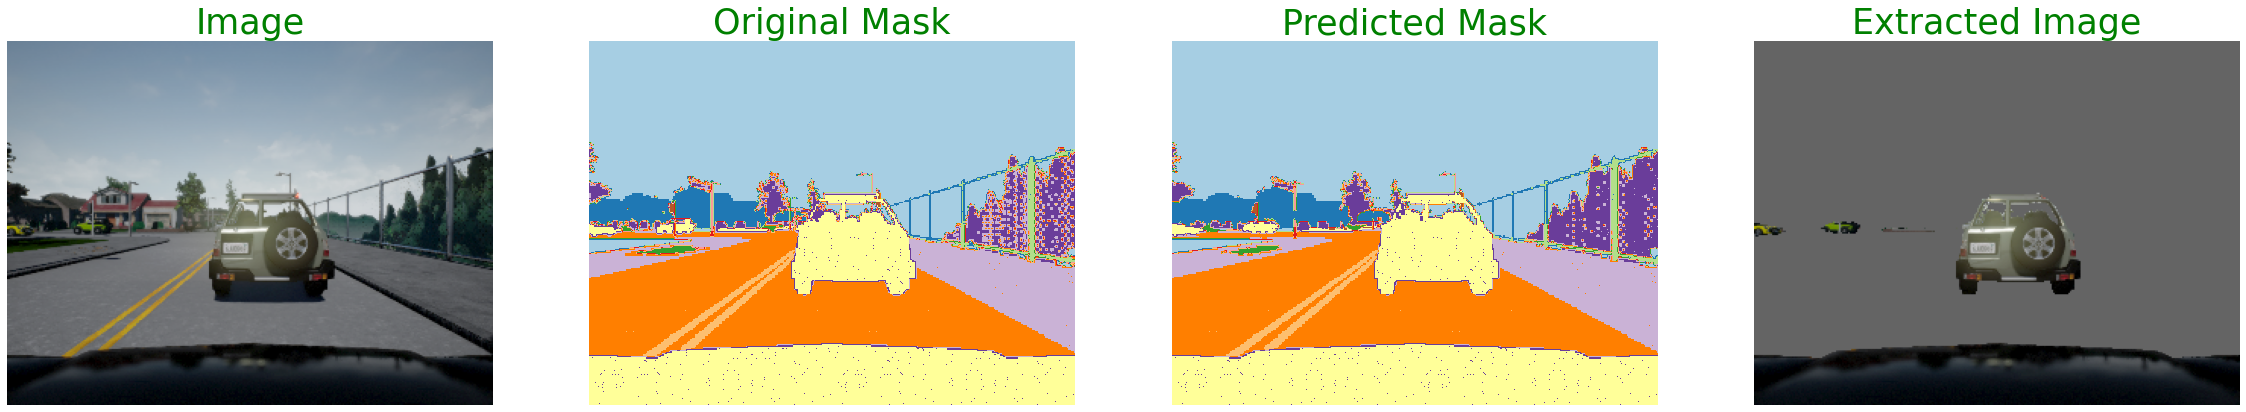

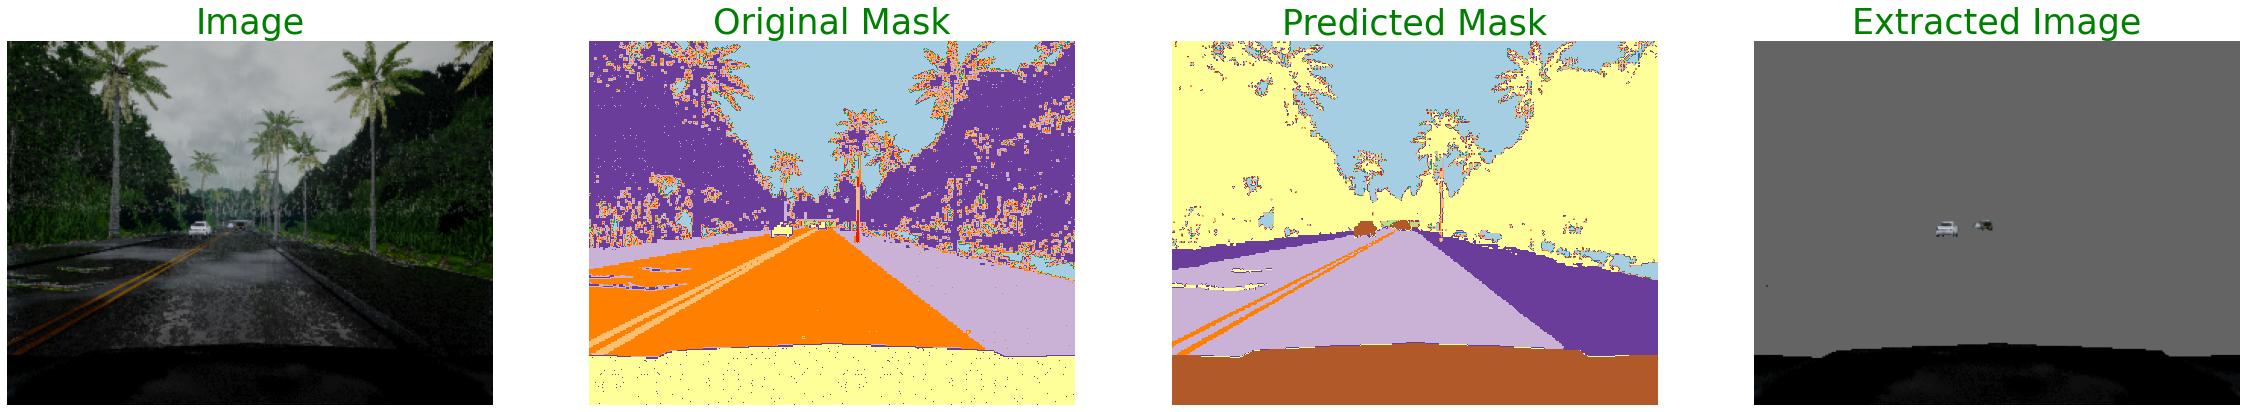

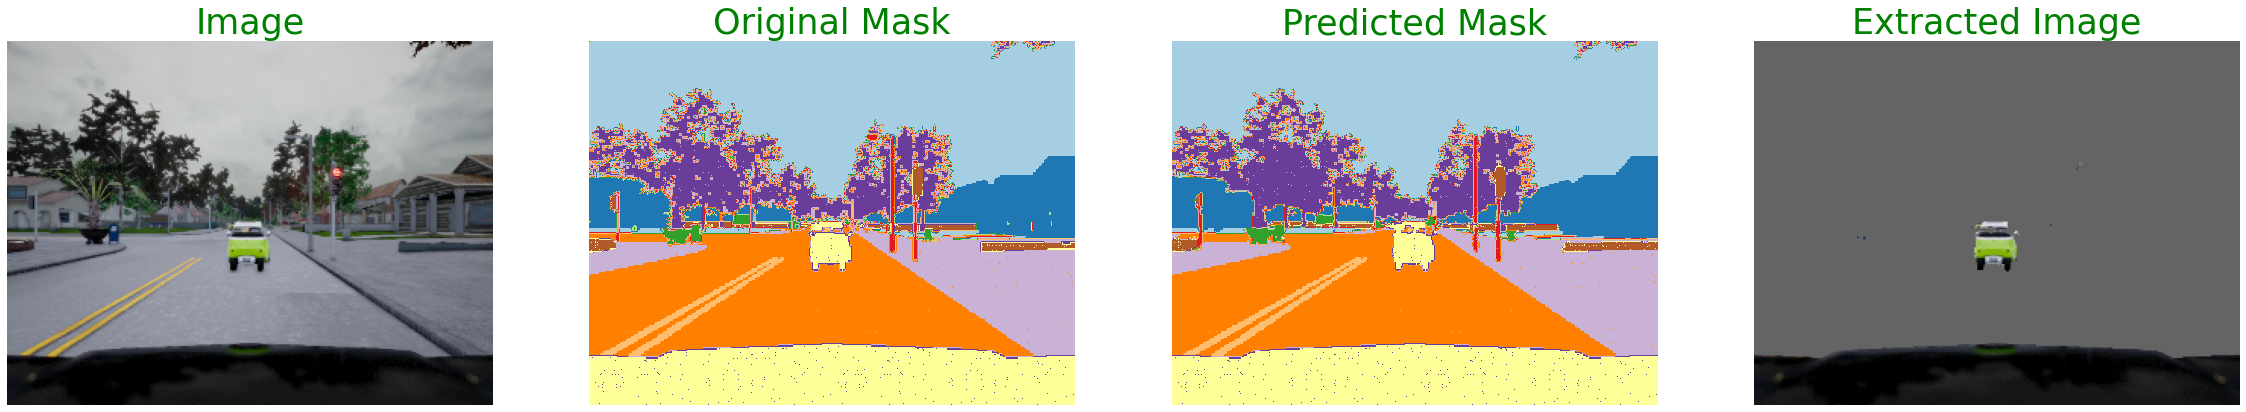

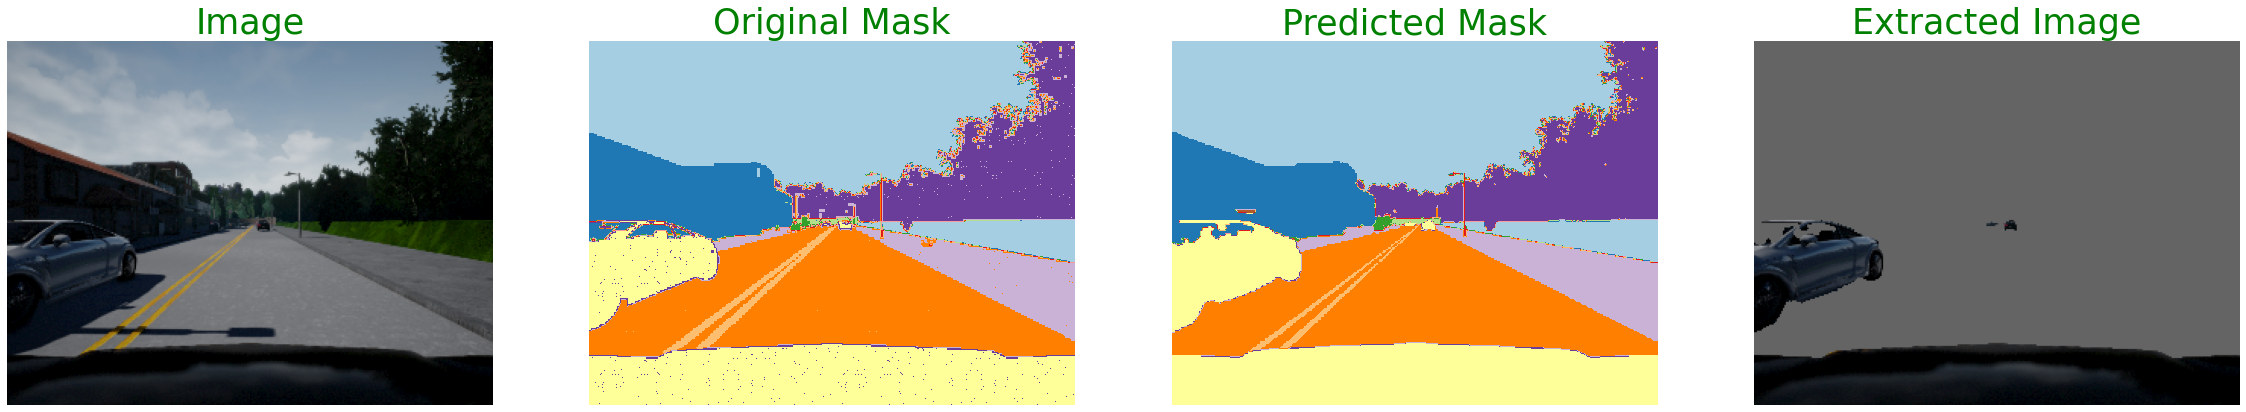

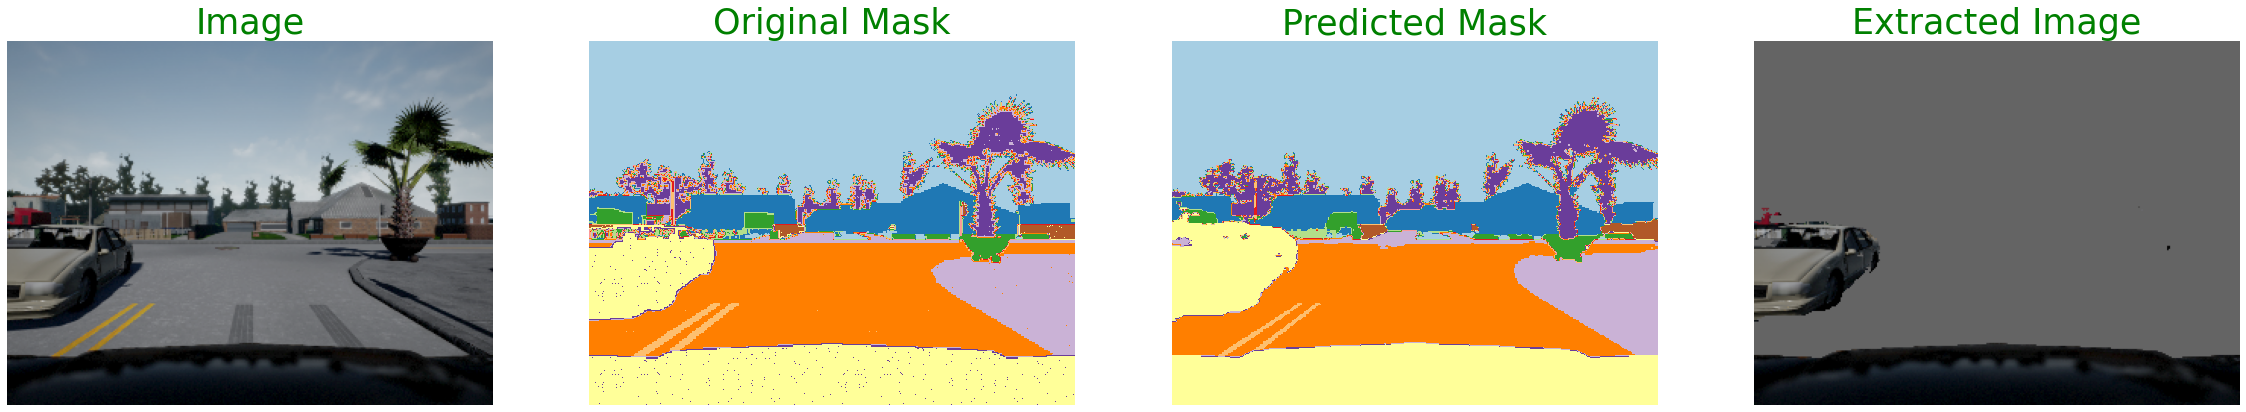

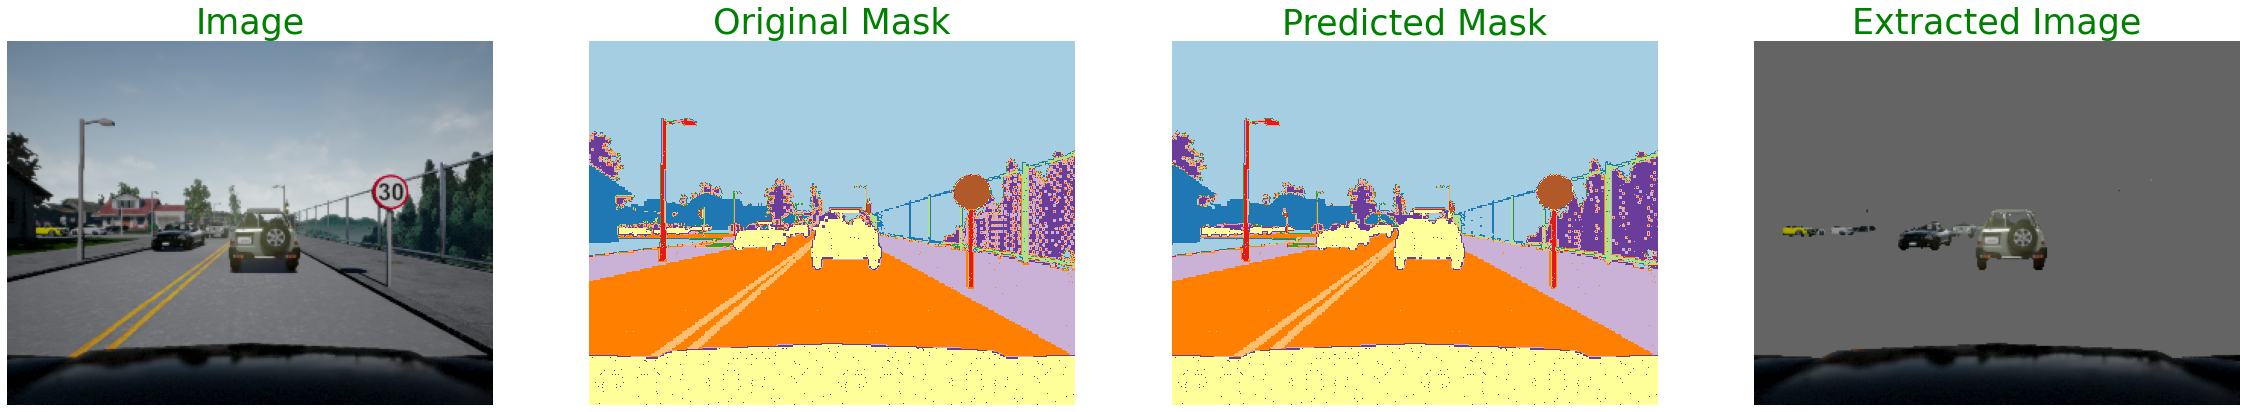

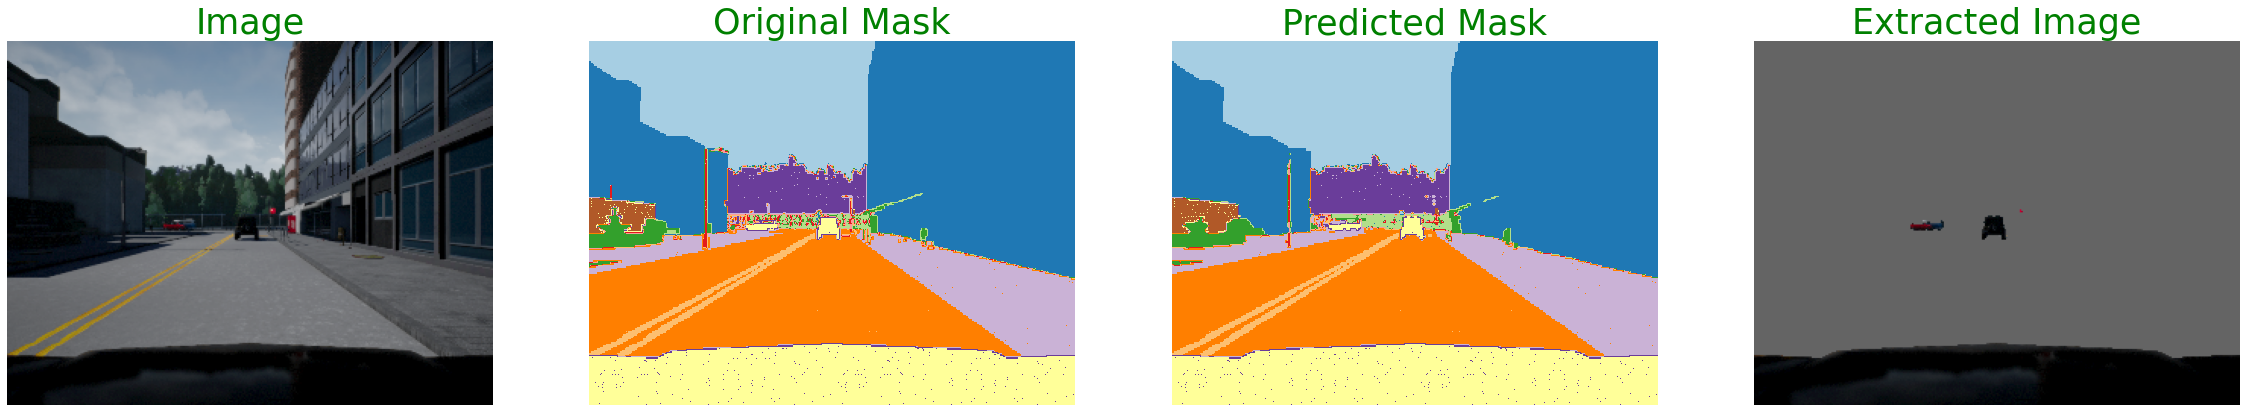

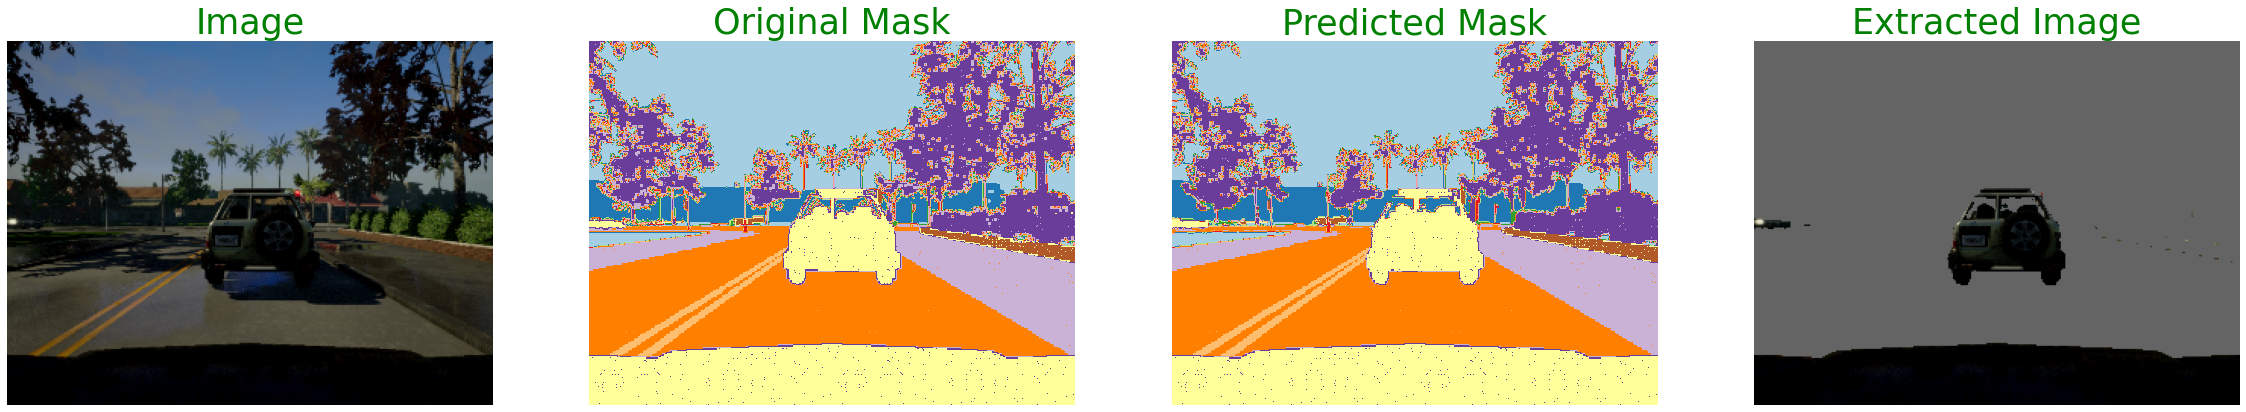

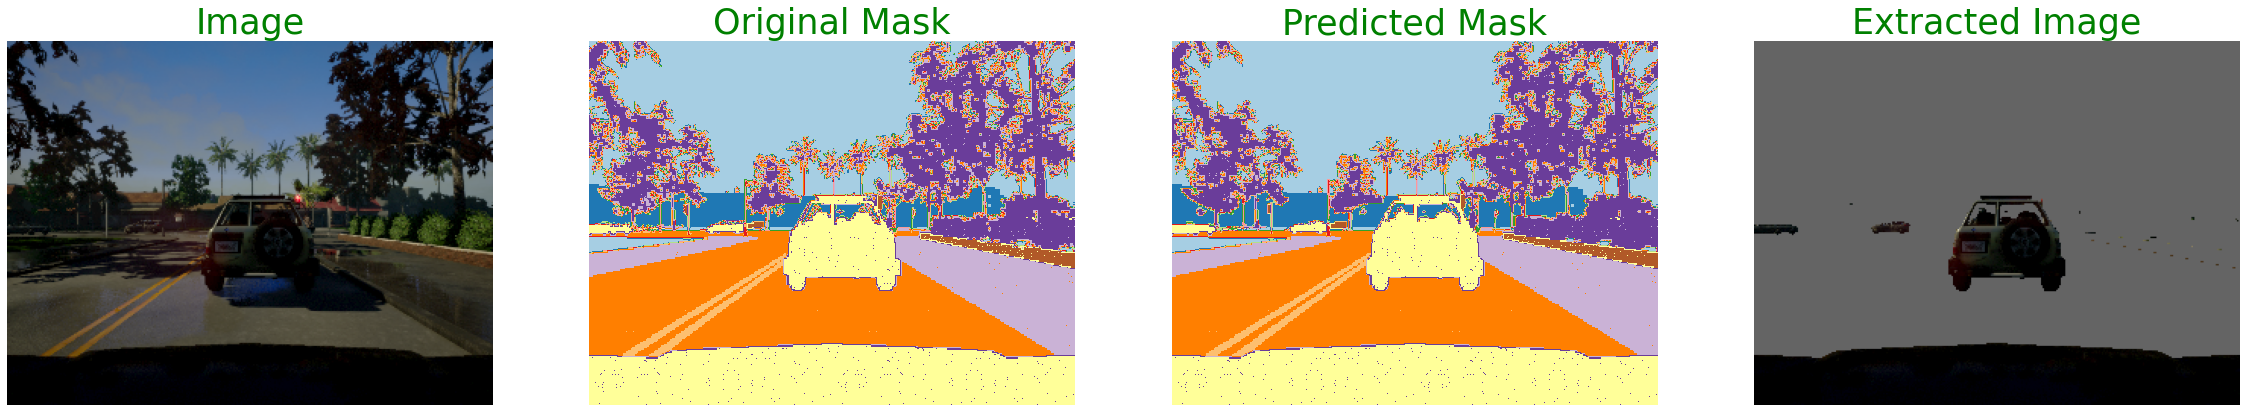

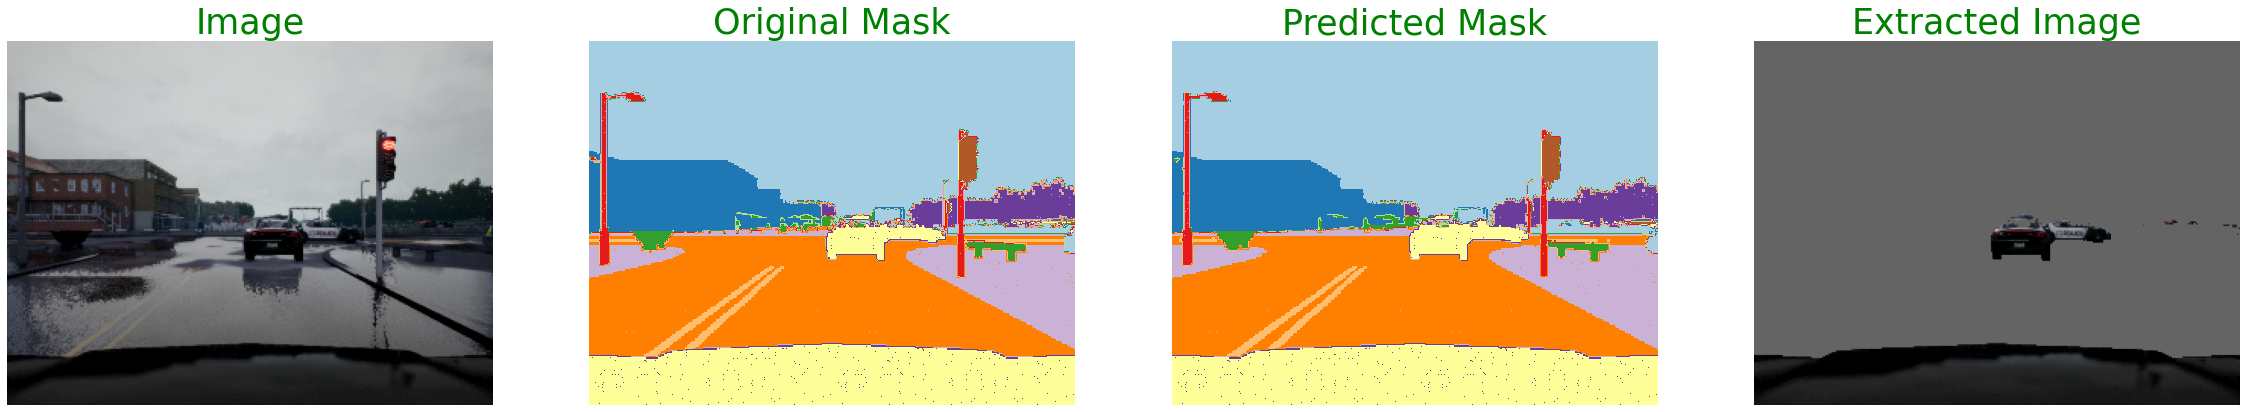

In [170]:
for _ in range(10):
    image, mask, prediction = make_predictions(model, random.randint(0, 5000))
    #prepare_plot(image, mask, isolate_label(prediction, 'Car'))
    prepare_plot(image, mask, prediction, detect_label(image, prediction, 'Car'))#'Car' 'Road'  'Roadline' 'Pedestrian'  'Traffic sign' 'Sidewalk'
